In [180]:
# This notebook shows an example of how to decode the data in the EvAAL API format to pandas DataFrame.
# Please note that the format of the txt file in ../trials/ is what returned through EvAAL API in the competition.
# In the real competition in September, you need to get data throught EvAAL API.
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sub import estimate

importlib.reload(estimate)

plt.rcParams["figure.figsize"] = (16.0, 6.0)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [181]:
# LOG_FILE_PATH = "../trials/Track5_second_evaluation_01_pdr.txt"
LOG_FILE_PATH = "../trials/4_1_51.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [182]:
from sub import pdr

importlib.reload(pdr)

data = pdr.read_log_data(LOG_FILE_PATH)
acc_df, gyro_df, mgf_df, ground_truth_df, ble_scans_df = pdr.convert_to_dataframes(data)
ble_positions_df = pd.read_csv(BEACON_LIST_PATH)

In [183]:
acc_df["norm"] = np.sqrt(acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2)

In [184]:
acc_df["norm"] = np.sqrt(acc_df["x"] ** 2 + acc_df["y"] ** 2 + acc_df["z"] ** 2)
# 時間が25秒以上50秒未満のデータを抽出
time_filter_acc = acc_df[(acc_df.ts >= 25) & (acc_df.ts < 35)]
time_filter_acc.reset_index(inplace=True, drop=True)

In [185]:
# 移動平均フィルターをかける
time_filter_acc.loc[:, "rolling_norm"] = time_filter_acc["norm"].rolling(10).mean()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_5427/259520140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filter_acc.loc[:, "rolling_norm"] = time_filter_acc["norm"].rolling(10).mean()


In [186]:
# ピーク検出
from scipy.signal import find_peaks

acc_df["rolling_norm"] = acc_df["norm"].rolling(10).mean()
peaks, _ = find_peaks(acc_df["rolling_norm"], height=12, distance=10)

In [187]:
gyro_in_step_timing = pd.DataFrame()
# ピーク時のジャイロの値を取得
gyro_in_step_timing = estimate.match_data(gyro_df, acc_df.ts[peaks])
# 角度データフレームの生成
angle_df = estimate.convert_to_angle_from_gyro(gyro_df)
# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()
angle_in_step_timing = estimate.match_data(angle_df, acc_df.ts[peaks])

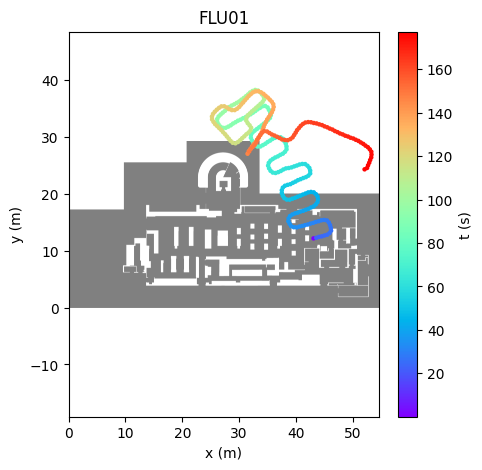

In [188]:
from sub import utils

importlib.reload(utils)
# 1 pixel of bmp represents 0.01 m
dx = 0.01
dy = 0.01

floor_name = ground_truth_df["floor_name"][0]
map_dict = pdr.load_floor_maps(FLOOR_NAMES, "../gis/")
peek_angle = estimate.convert_to_peek_angle(gyro_df, acc_df, peaks)


cumulative_displacement_df = estimate.calculate_cumulative_displacement(
    peek_angle.ts,
    peek_angle["x"],
    0.5,
    {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
    ground_truth_df["ts"][0],
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    cumulative_displacement_df,
)

In [189]:
import numpy as np
import pandas as pd
from sub import ble, ble_fingerprint

importlib.reload(ble_fingerprint)
importlib.reload(ble)

# 軌跡前半の歩行軌跡の座標と強いBLEビーコンの位置座標の距離が最小になる角度を探索
# これは軌跡前半はドリフトが乗りづらいため
# 時間全体の中央を変数に入れる
center_of_time = ble_scans_df.tail(1)["ts"].to_numpy() / 2
# center_of_time = float(center_of_time)

first_half_strong_blescans = estimate.filter_strong_blescans(
    ble_scans_df,
    180,
    -70,
)

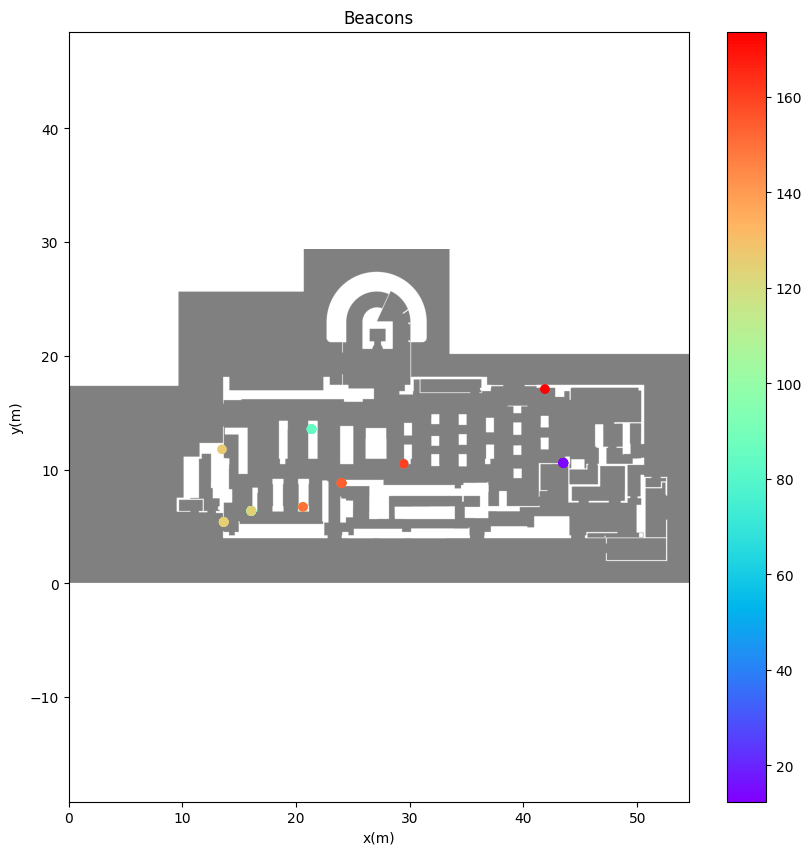

In [190]:
merged_strong_blescans_first_half = estimate.load_beacons_and_merge(
    BEACON_LIST_PATH,
    first_half_strong_blescans,
)


# マップ上にビーコンの位置をプロット
estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        merged_strong_blescans_first_half.x,
        merged_strong_blescans_first_half.y,
        c=merged_strong_blescans_first_half["ts"],
        cmap="rainbow",
    ),
)
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("Beacons")
plt.show()

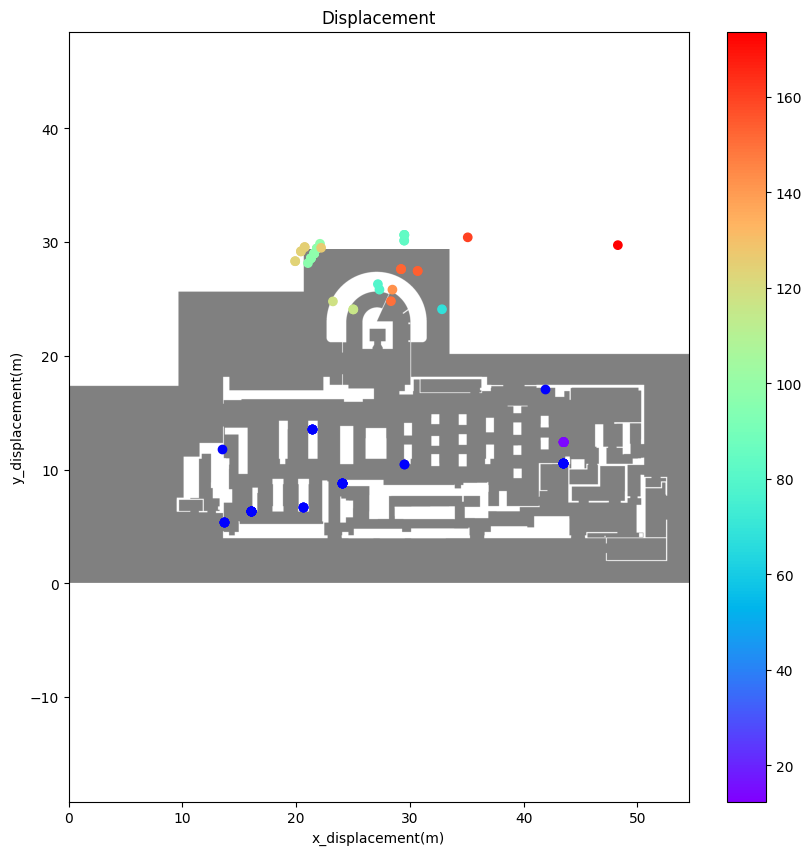

In [196]:
rotated_cumulative_displacement_df = estimate.rotate_cumulative_displacement(
    cumulative_displacement_df,
    0.3,
    {"x": ground_truth_df.x[0], "y": ground_truth_df.y[0]},
)


# 同じ bdaddress, x, y を持つデータをグループ化
merged_df = pd.merge_asof(
    merged_strong_blescans_first_half,
    rotated_cumulative_displacement_df,
    on="ts",
    direction="nearest",
)


# マップ上にx_displacement,y_displacementとビーコンの位置をプロット
estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        merged_df.x_displacement,
        merged_df.y_displacement,
        c=merged_df["ts"],
        cmap="rainbow",
    ),
)

# plt.colorbar(
#     plt.scatter(
#         merged_df.x,
#         merged_df.y,
#         c=merged_df["ts"],
#         cmap="rainbow",
#     ),
# )

plt.scatter(merged_df.x, merged_df.y, c="blue")


plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

In [192]:
from sub import drift

first_time_remove_drift_angle_df, first_time_remove_drift_angle_displacement = (
    drift.remove_drift_in_angle_df(
        acc_df,
        angle_df,
        ground_truth_df,
    )
)

        x     y    z     beacon_address  floor  rssi_mean   rssi_std  count  \
0    43.2  12.4  1.1  C0:1C:4D:44:32:56  FLU01 -69.625000   6.843923      8   
1    41.5  11.6  1.3  C0:1C:4D:44:32:56  FLU01 -69.352941  10.723462     17   
2    41.7  11.6  1.3  C0:1C:4D:44:32:56  FLU01 -66.642857   9.888666     14   
3    27.9  10.7  1.3  C0:1C:4D:47:CF:0A  FLU01 -66.500000   7.416198     12   
4    27.8  10.7  1.3  C0:1C:4D:47:CF:0A  FLU01 -68.176471  11.668522     17   
5    26.6  10.6  1.3  C0:1C:4D:47:CF:0A  FLU01 -69.900000   8.116513     10   
6    28.6  11.9  1.3  C0:1C:4D:47:CF:0A  FLU01 -68.545455   6.578201     11   
7    28.5  11.7  1.2  C0:1C:4D:47:CF:0A  FLU01 -69.444444   9.408920      9   
8    27.0  10.6  1.3  C0:1C:4D:47:CF:0A  FLU01 -69.000000   8.225975      7   
9    26.8  10.1  1.3  C0:1C:4D:47:CF:0A  FLU01 -69.555556   8.819171      9   
10   27.1   9.9  1.3  C0:1C:4D:47:CF:0A  FLU01 -69.700000  12.184234     10   
11   28.4  10.2  1.3  C0:1C:4D:47:CF:0A  FLU01 -69.7

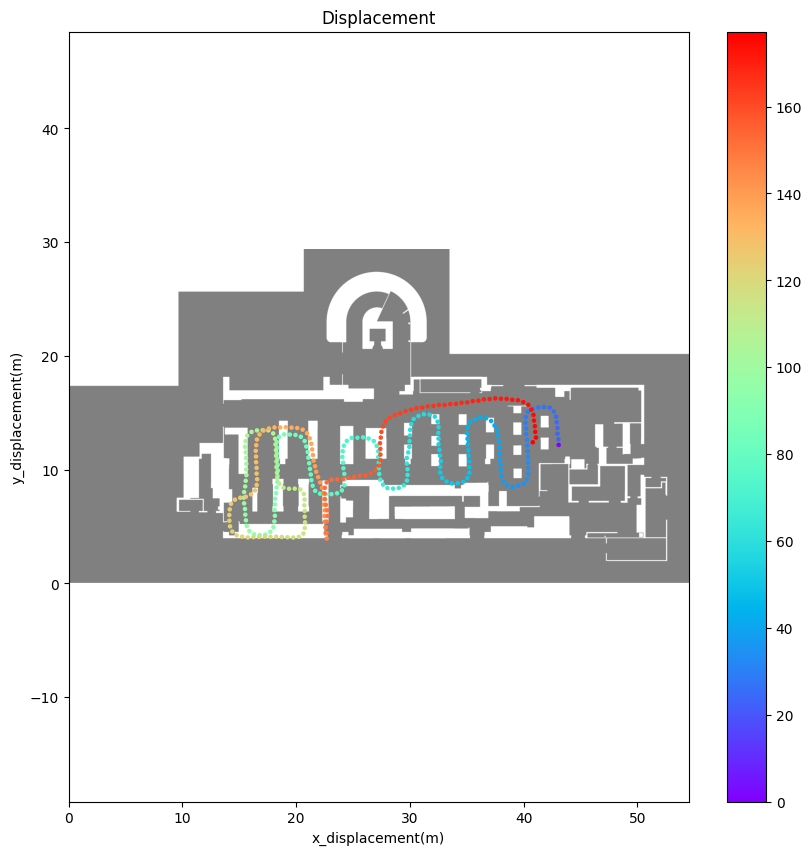

In [198]:
import numpy as np
import pandas as pd
from sub import ble, ble_fingerprint

importlib.reload(ble_fingerprint)
importlib.reload(ble)

ble_fingerprint_df = pd.read_csv("./beacon_reception_events.csv")

rotated_optimal_angle_df, rotated_optimal_displacement_df = (
    ble_fingerprint.rotate_trajectory_to_optimal_alignment_using_ble_fingerprint(
        acc_df,
        first_time_remove_drift_angle_df,
        first_half_strong_blescans,
        ble_fingerprint_df,
        floor_name,
        ground_truth_first_point={
            "x": ground_truth_df.x[0],
            "y": ground_truth_df.y[0],
        },
    )
)

estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        rotated_optimal_displacement_df.x_displacement,
        rotated_optimal_displacement_df.y_displacement,
        c=rotated_optimal_displacement_df.ts,
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

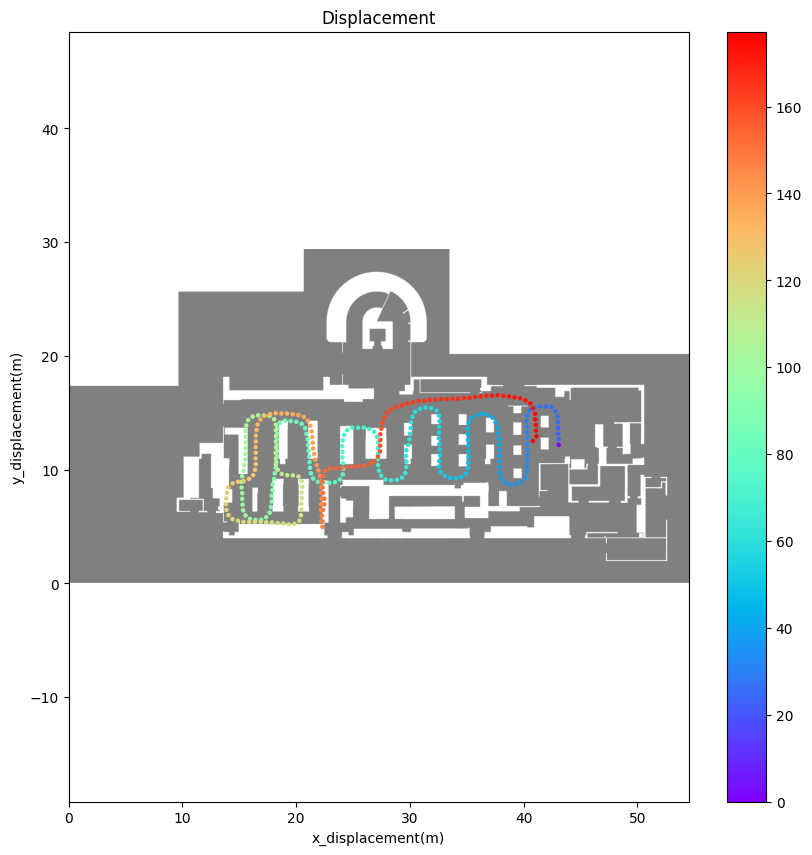

In [194]:
from sub import ble

importlib.reload(ble)

rotated_optimal_angle_df, rotated_optimal_displacement_df = (
    ble.rotate_trajectory_to_optimal_alignment_using_ble(
        acc_df,
        first_time_remove_drift_angle_df,
        ble_scans_df,
        ble_positions_df,
        ground_truth_first_point={
            "x": ground_truth_df.x[0],
            "y": ground_truth_df.y[0],
        },
    )
)


estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        rotated_optimal_displacement_df.x_displacement,
        rotated_optimal_displacement_df.y_displacement,
        c=rotated_optimal_displacement_df.ts,
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()